In [83]:
import tensorflow as tf
from tensorflow.data import TFRecordDataset, AUTOTUNE
# import tf.data.TFRecordDataset
import jax
from typing import Optional
from waymax.config import DatasetConfig, DataFormat
import jax.numpy as jnp
import functools


In [84]:
path = "./uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000"
myconfig = DatasetConfig(
    path = "./uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000",
    max_num_rg_points=20000,
    data_format=DataFormat.TFRECORD,
)

In [93]:
from waymax.dataloader import womd_utils
def preprocess_serialized_womd_data(
    serialized: bytes, config: DatasetConfig
) -> dict[str, tf.Tensor]:
  """Parses serialized tf example into tf Tensor dict."""
  womd_features = womd_utils.get_features_description(
      include_sdc_paths=config.include_sdc_paths,
      max_num_rg_points=config.max_num_rg_points,
      num_paths=config.num_paths,
      num_points_per_path=config.num_points_per_path,
  )

  deserialized = tf.io.parse_example(serialized, womd_features)
  insight(deserialized, "before_aggregate")
  return preprocess_womd_example(
      deserialized,
      aggregate_timesteps=config.aggregate_timesteps,
      max_num_objects=config.max_num_objects,
  )


def preprocess_womd_example(
    example: dict[str, tf.Tensor],
    aggregate_timesteps: bool,
    max_num_objects: Optional[int] = None,
) -> dict[str, tf.Tensor]:
  """Preprocesses dict of tf tensors, keyed by str."""

  if aggregate_timesteps:
    processed = womd_utils.aggregate_time_tensors(example)
    wrap_yaws = lambda yaws: (yaws + jnp.pi) % (2 * jnp.pi) - jnp.pi
    processed['state/all/bbox_yaw'] = wrap_yaws(processed['state/all/bbox_yaw'])
  else:
    processed = example

  if max_num_objects is not None:
    # TODO check sdc included if it is needed.
    return {
        k: v[:max_num_objects] if k.startswith('state/') else v
        for k, v in processed.items()
    }
  else:
    return processed

def insight(data: dict[str: tf.Tensor], prefix: str):
  with open(f"{prefix}_insight.txt", mode='w') as f:
    for key in data:
          f.write(f"key: {key}, value shape: {data[key].shape}, dim: {data[key].ndim}\n")


In [94]:
files_to_load = [path]
files = tf.data.Dataset.from_tensor_slices(files_to_load)

files = files.shard(jax.process_count(), jax.process_index())



In [95]:
data = files.interleave(tf.data.TFRecordDataset, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
# data = tf.data.TFRecordDataset(files)
# myconfig.aggregate_timesteps = False
preprocess_fn = functools.partial(preprocess_serialized_womd_data, config = myconfig)

# insight(data, "before_aggregate")

data = data.map(
    preprocess_fn, num_parallel_calls=AUTOTUNE, deterministic=True
)



In [96]:
for item in data.take(1):
    insight(item, "after_aggregate")

In [107]:
from waymax.dataloader import womd_factories

for item in data.take(1):
    # for k in item:
    #     print(k, item[k].shape)
    s = womd_factories.simulator_state_from_womd_dict(item)

Trajectory(x=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), y=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), z=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), vel_x=Array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
    

In [29]:
print(myconfig.include_sdc_paths, myconfig.max_num_rg_points, myconfig.num_paths,myconfig.num_points_per_path)

print(myconfig.aggregate_timesteps, myconfig.max_num_objects)

False 20000 None None
True None


In [38]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)
print(type(x))

[0 1 2 3 4 5 6 7 8 9]
<class 'jaxlib.xla_extension.ArrayImpl'>


In [39]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

3.83 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
def sum_of_squares(x):
  return jnp.sum(x**2)

sum_of_squares_dx = jax.grad(sum_of_squares)

x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))

print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [42]:
def sum_squared_error(x, y):
  return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error)

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

print(sum_squared_error_dx(x, y))

[-0.20000005 -0.19999981 -0.19999981 -0.19999981]


(Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32),)
1.9489917853651297 -1.981586552048152
0.2477871269328129 -0.24415047100582213


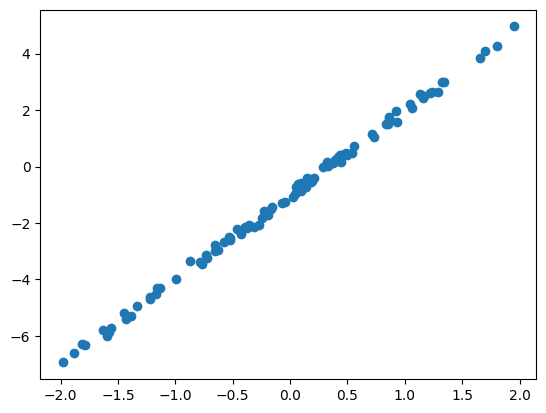

In [55]:
a = jax.grad(sum_squared_error, argnums=(1,))(x, y)  # Find gradient wrt both x & y
print(a)
# print(b)

import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
print(xs.max(),xs.min())
noise = np.random.normal(scale=0.1, size=(100,))
print(noise.max(), noise.min())
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [56]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [57]:
def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [65]:
@jax.jit
def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 2.99, b: -1.01


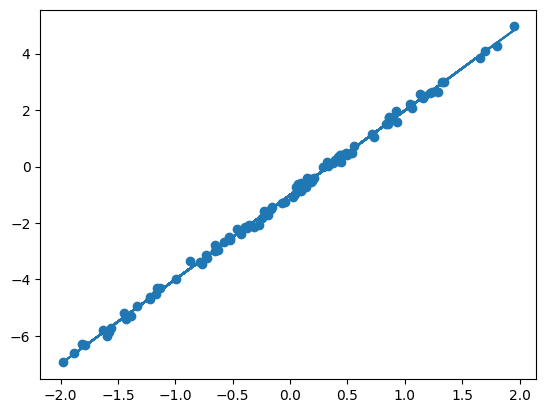

In [66]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

In [67]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }
